In [81]:
%matplotlib inline
import math
import numpy as np
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
from statsmodels.graphics import tsaplots #statistical package for ACF and PACF
import statsmodels.api as sm 
from statsmodels.api import OLS
import statsmodels.tsa.stattools as tsa  
plt.style.use('bmh')
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from pandas.plotting import autocorrelation_plot #autocorrelation plot in Pandas
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
import matplotlib.ticker as mticker
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.tsa.api as smtsa
from itertools import product                    # some useful functions
from tqdm import tqdm_notebook
from scipy import stats
from pandas.plotting import lag_plot
from mpl_finance import candlestick_ohlc
import matplotlib.dates as mdates
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.api import VAR


In [28]:
#set working directory

os.chdir('C:/Users/Andrea/Jupyter Notebooks/Master Thesis')

Bitcoin price dataset

In [3]:
#load the file

btc_price = pd.read_csv('bitcoin_price.csv', parse_dates = ['Date'], index_col = 'Date')


In [4]:
#preprocessing
btc_price.columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'Market_Cap']
btc_price['Volume_mil'] = pd.to_numeric(btc_price['Volume'].str.replace(",","").str.replace("-","")).div(1e6)
btc_price['Market_Cap_mil'] = pd.to_numeric(btc_price['Market_Cap'].str.replace(",","").str.replace("-","")).div(1e6)
btc_price.sort_index(inplace=True)
btc_price.drop(['Volume', 'Market_Cap'], axis = 1, inplace=True)

In [5]:
btc_price.head()

,Open,High,Low,Close,Volume_mil,Market_Cap_mil
Date,,,,,,
2013-04-28,135.30,135.98,132.10,134.21,NaN,1488.566728
2013-04-29,134.44,147.49,134.00,144.54,NaN,1603.768865
2013-04-30,144.00,146.93,134.05,139.00,NaN,1542.813125
2013-05-01,139.00,139.89,107.72,116.99,NaN,1298.954594
2013-05-02,116.38,125.60,92.28,105.21,NaN,1168.517495


In [5]:
btc_price.dropna(inplace=True)

In [6]:
btc_price.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1971 entries, 2013-12-27 to 2019-05-20
Data columns (total 6 columns):
Open              1971 non-null float64
High              1971 non-null float64
Low               1971 non-null float64
Close             1971 non-null float64
Volume_mil        1971 non-null float64
Market_Cap_mil    1971 non-null float64
dtypes: float64(6)
memory usage: 107.8 KB


https://github.com/dashee87/blogScripts/blob/master/Jupyter/2017-11-20-predicting-cryptocurrency-prices-with-deep-learning.ipynb


D:\andrea\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Date')

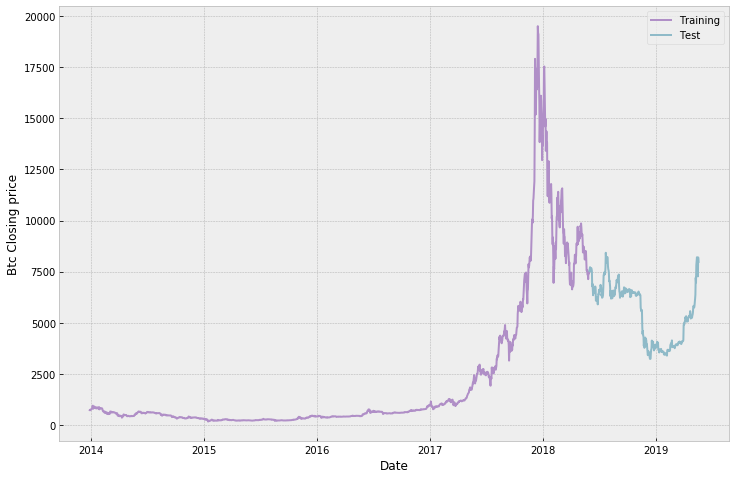

In [7]:
#create train and test data

split_date = '2018-06-01'
fig = plt.figure(figsize=(12,8))
plt.subplot(111)
plt.plot(btc_price[:split_date]['Close'], color='#B08FC7', label='Training')
plt.plot(btc_price[split_date:]['Close'], color='#8FBAC8', label='Test')
plt.legend(loc = 'best')
plt.ylabel('Btc Closing price')
plt.xlabel('Date')


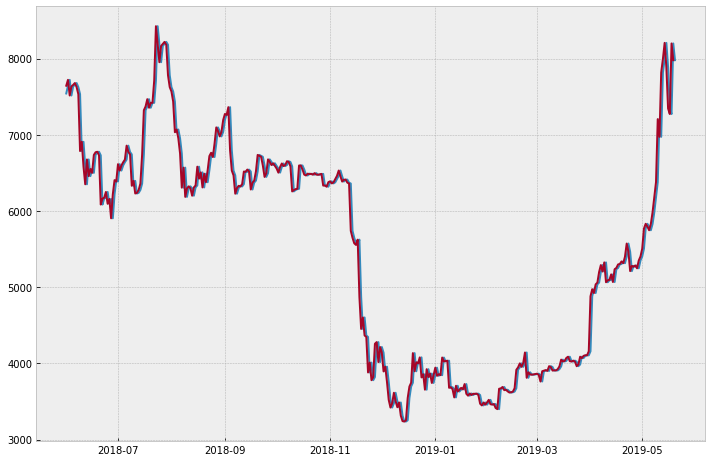

In [38]:
#basic model: today price equal to yestarday price

fig = plt.figure(figsize=(12,8))
plt.subplot(111)
plt.plot(btc_price[split_date:]['Close'], label='Actual')
plt.plot(btc_price[split_date:]['Close'].shift(-1), label = 'Predicted')


In [ ]:
#let's treat Btc Closing price as a realization of a random walk
#btc_price.Close.diff().dropna().plot(kind = 'hist', bins = 200)
np.random.seed(202)
bt_r_walk_mean, bt_r_walk_sd = np.mean(btc_price[:split_date]['Close'].diff().dropna().values), \
                         np.std(btc_price[:split_date]['Close'].diff().dropna().values)
#create a datetime series random normal distribution
bt_random_steps = np.random.normal(bt_r_walk_mean, bt_r_walk_sd, 
                (max(btc_price.index).to_pydatetime() - datetime.datetime.strptime(split_date, '%Y-%m-%d')).days + 1)

fig = plt.figure(figsize=(12,8))
plt.subplot(111)

plt.plot(btc_price.index[split_date+1:]['Close'], label='Actual') 
#multiply yestarday price with the random value for that day
plt.plot(btc_price.index[split_date+1:]['Close'].shift(1) * (1+bt_random_steps), label='Predicted')

In [8]:
# https://github.com/dashee87/blogScripts/blob/master/Jupyter/2017-11-20-predicting-cryptocurrency-prices-with-deep-learning.ipynb

#feature engineering

kwargs = { 'close_off_high': lambda x: 2*(x['High']- x['Close'])/(x['High']-x['Low'])-1,
          'volatility': lambda x: (x['High']- x['Low'])/(x['Open'])}
btc_price = btc_price.assign(**kwargs)

model_data = btc_price[['Close','Volume_mil','close_off_high','volatility']]
model_data.head()

,Close,Volume_mil,close_off_high,volatility
Date,,,,
2013-12-27,735.07,46.8627,0.328118,0.083731
2013-12-28,727.83,32.5058,-0.077919,0.056519
2013-12-29,745.05,19.0113,-0.791630,0.046934
2013-12-30,756.13,20.7077,-0.205615,0.035557
2013-12-31,754.01,20.8973,-0.413655,0.029474


In [9]:
training_set, test_set = model_data[:'2018-05-31'], model_data[split_date:]

In [10]:
window_len = 10
norm_cols = ['Close', 'Volume_mil']

In [11]:
LSTM_training_inputs = []
for i in range(len(training_set)-window_len):
    temp_set = training_set[i:(i+window_len)].copy()
    for col in norm_cols:
        temp_set.loc[:, col] = temp_set[col]/temp_set[col].iloc[0] - 1
    LSTM_training_inputs.append(temp_set)
LSTM_training_outputs = (training_set['Close'][window_len:].values/training_set['Close'][:-window_len].values)-1

In [12]:
LSTM_test_inputs = []
for i in range(len(test_set)-window_len):
    temp_set = test_set[i:(i+window_len)].copy()
    for col in norm_cols:
        temp_set.loc[:, col] = temp_set[col]/temp_set[col].iloc[0] - 1
    LSTM_test_inputs.append(temp_set)
LSTM_test_outputs = (test_set['Close'][window_len:].values/test_set['Close'][:-window_len].values)-1

In [13]:
LSTM_training_inputs = [np.array(LSTM_training_input) for LSTM_training_input in LSTM_training_inputs]
LSTM_training_inputs = np.array(LSTM_training_inputs)

LSTM_test_inputs = [np.array(LSTM_test_inputs) for LSTM_test_inputs in LSTM_test_inputs]
LSTM_test_inputs = np.array(LSTM_test_inputs)

In [14]:
# import the relevant Keras modules
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import LSTM
from keras.layers import Dropout

def build_model(inputs, output_size, neurons, activ_func="linear",
                dropout=0.25, loss="mae", optimizer="adam"):
    model = Sequential()

    model.add(LSTM(neurons, input_shape=(inputs.shape[1], inputs.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

Using TensorFlow backend.


In [15]:
# random seed for reproducibility
np.random.seed(202)
# initialise model architecture
eth_model = build_model(LSTM_training_inputs, output_size=1, neurons = 20)
# model output is next price normalised to 10th previous closing price
LSTM_training_outputs = (training_set['Close'][window_len:].values/training_set['Close'][:-window_len].values)-1
# train model on data
# note: eth_history contains information on the training error per epoch
eth_history = eth_model.fit(LSTM_training_inputs, LSTM_training_outputs, 
                            epochs=50, batch_size=1, verbose=2, shuffle=True)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/50
 - 6s - loss: 0.0557
Epoch 2/50
 - 5s - loss: 0.0402
Epoch 3/50
 - 5s - loss: 0.0355
Epoch 4/50
 - 5s - loss: 0.0339
Epoch 5/50
 - 5s - loss: 0.0331
Epoch 6/50
 - 6s - loss: 0.0321
Epoch 7/50
 - 5s - loss: 0.0313
Epoch 8/50
 - 6s - loss: 0.0318
Epoch 9/50
 - 6s - loss: 0.0312
Epoch 10/50
 - 5s - loss: 0.0316
Epoch 11/50
 - 5s - loss: 0.0310
Epoch 12/50
 - 5s - loss: 0.0305
Epoch 13/50
 - 6s - loss: 0.0304
Epoch 14/50
 - 6s - loss: 0.0309
Epoch 15/50
 - 6s - loss: 0.0309
Epoch 16/50
 - 5s - loss: 0.0297
Epoch 17/50
 - 6s - loss: 0.0300
Epoch 18/50
 - 7s - loss: 0.0306
Epoch 19/50
 - 6s - loss: 0.0302
Epoch 20/50
 - 6s - loss: 0.0301
Epoch 21/50
 - 5s - loss: 0.0301
Epoch 22/50
 - 5s - loss: 0.0297
Epoch 23/50
 - 5s - loss: 0.0301
Epoch 24/50
 - 

Text(0.5, 0, '# Epochs')

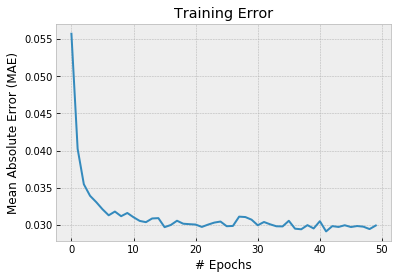

In [16]:
# MAE training error across epochs
fig, ax1 = plt.subplots(1,1)

ax1.plot(eth_history.epoch, eth_history.history['loss'])
ax1.set_title('Training Error')

if eth_model.loss == 'mae':
    ax1.set_ylabel('Mean Absolute Error (MAE)',fontsize=12)
# just in case you decided to change the model loss calculation
else:
    ax1.set_ylabel('Model Loss',fontsize=12)
ax1.set_xlabel('# Epochs',fontsize=12)

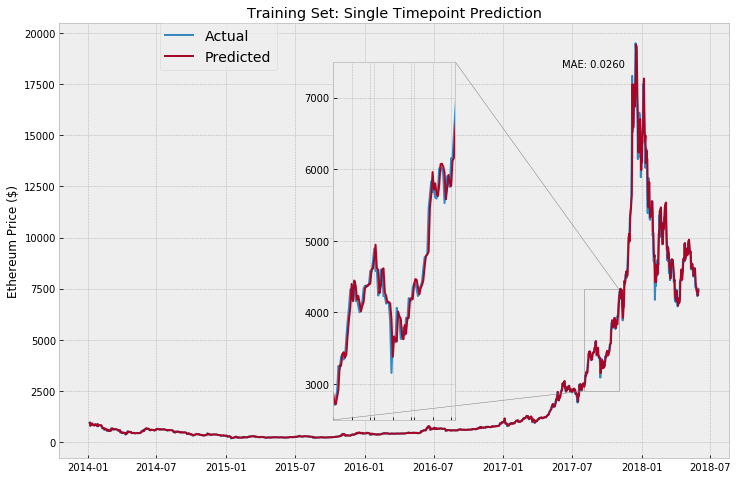

In [31]:
#performance on training test

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

fig, ax1 = plt.subplots(1,1, figsize = (12,8))
ax1.plot(training_set['Close'][window_len:], label='Actual')
ax1.plot(training_set.index[window_len:],
         ((np.transpose(eth_model.predict(LSTM_training_inputs))+1) * training_set['Close'].values[:-window_len])[0], 
         label='Predicted')
ax1.set_title('Training Set: Single Timepoint Prediction')
ax1.set_ylabel('Ethereum Price ($)',fontsize=12)
ax1.legend(bbox_to_anchor=(0.15, 1), loc=2, borderaxespad=0., prop={'size': 14})
ax1.annotate('MAE: %.4f'%np.mean(np.abs((np.transpose(eth_model.predict(LSTM_training_inputs))+1)-\
            (training_set['Close'].values[window_len:])/(training_set['Close'].values[:-window_len]))), 
             xy=(0.75, 0.9),  xycoords='axes fraction',
            xytext=(0.75, 0.9), textcoords='axes fraction')
# figure inset code taken from http://akuederle.com/matplotlib-zoomed-up-inset
axins = zoomed_inset_axes(ax1, 3.5, loc=10) # zoom-factor: 3.35, location: centre
axins.plot(training_set['Close'][window_len:], label='Actual')
axins.plot(training_set.index[window_len:],
         ((np.transpose(eth_model.predict(LSTM_training_inputs))+1) * training_set['Close'].values[:-window_len])[0], 
         label='Predicted')
axins.set_xlim([datetime.date(2017, 8, 1), datetime.date(2017, 11, 1)])
axins.set_ylim([2500,7500])
axins.set_xticklabels('')
mark_inset(ax1, axins, loc1=1, loc2=3, fc="none", ec="0.5")
plt.show()

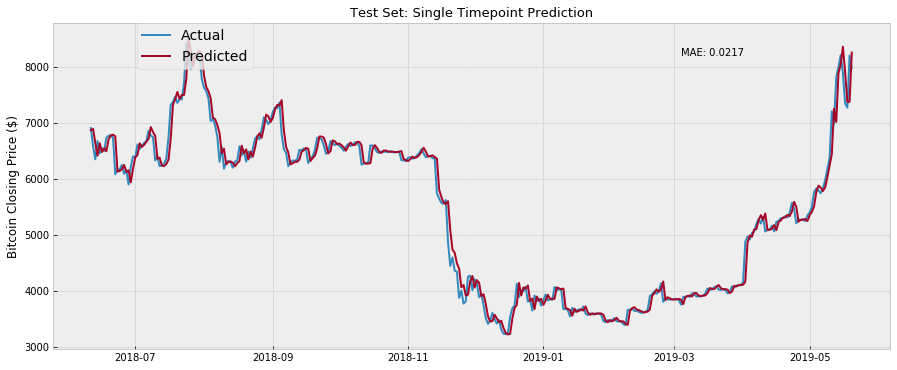

In [33]:
# performance of test set

fig, ax1 = plt.subplots(1,1)
ax1.plot(test_set['Close'][window_len:], label='Actual')
ax1.plot(test_set.index[window_len:],
         ((np.transpose(eth_model.predict(LSTM_test_inputs))+1) * test_set['Close'].values[:-window_len])[0], 
         label='Predicted')
ax1.annotate('MAE: %.4f'%np.mean(np.abs((np.transpose(eth_model.predict(LSTM_test_inputs))+1)-\
            (test_set['Close'].values[window_len:])/(test_set['Close'].values[:-window_len]))), 
             xy=(0.75, 0.9),  xycoords='axes fraction',
            xytext=(0.75, 0.9), textcoords='axes fraction')
ax1.set_title('Test Set: Single Timepoint Prediction',fontsize=13)
ax1.set_ylabel('Bitcoin Closing Price ($)',fontsize=12)
ax1.legend(bbox_to_anchor=(0.1, 1), loc=2, borderaxespad=0., prop={'size': 14})


In [ ]:
#single point predictions can be deceptive

In [38]:
# We'll now build LSTM models to predict crypto prices for the next 5 days.
# random seed for reproducibility
np.random.seed(202)
# we'll try to predict the closing price for the next 5 days 
# change this value if you want to make longer/shorter prediction
pred_range = 5
# initialise model architecture
btc_model = build_model(LSTM_training_inputs, output_size=pred_range, neurons = 20)
# model output is next 5 prices normalised to 10th previous closing price
LSTM_training_outputs = []
for i in range(window_len, len(training_set['Close'])-pred_range):
    LSTM_training_outputs.append((training_set['Close'][i:i+pred_range].values/
                                  training_set['Close'].values[i-window_len])-1)
LSTM_training_outputs = np.array(LSTM_training_outputs)

# train model on data
# note: eth_history contains information on the training error per epoch
eth_history = btc_model.fit(LSTM_training_inputs[:-pred_range], LSTM_training_outputs, 
                            epochs=50, batch_size=1, verbose=2, shuffle=True)

Epoch 1/50
 - 6s - loss: 0.0714
Epoch 2/50
 - 5s - loss: 0.0564
Epoch 3/50
 - 5s - loss: 0.0548
Epoch 4/50
 - 6s - loss: 0.0536
Epoch 5/50
 - 5s - loss: 0.0515
Epoch 6/50
 - 6s - loss: 0.0507
Epoch 7/50
 - 5s - loss: 0.0517
Epoch 8/50
 - 5s - loss: 0.0511
Epoch 9/50
 - 5s - loss: 0.0506
Epoch 10/50
 - 5s - loss: 0.0506
Epoch 11/50
 - 5s - loss: 0.0510
Epoch 12/50
 - 5s - loss: 0.0508
Epoch 13/50
 - 6s - loss: 0.0506
Epoch 14/50
 - 5s - loss: 0.0505
Epoch 15/50
 - 6s - loss: 0.0502
Epoch 16/50
 - 6s - loss: 0.0503
Epoch 17/50
 - 6s - loss: 0.0503
Epoch 18/50
 - 6s - loss: 0.0505
Epoch 19/50
 - 6s - loss: 0.0505
Epoch 20/50
 - 6s - loss: 0.0503
Epoch 21/50
 - 6s - loss: 0.0500
Epoch 22/50
 - 6s - loss: 0.0500
Epoch 23/50
 - 6s - loss: 0.0499
Epoch 24/50
 - 7s - loss: 0.0498
Epoch 25/50
 - 6s - loss: 0.0496
Epoch 26/50
 - 6s - loss: 0.0499
Epoch 27/50
 - 6s - loss: 0.0497
Epoch 28/50
 - 6s - loss: 0.0502
Epoch 29/50
 - 6s - loss: 0.0499
Epoch 30/50
 - 6s - loss: 0.0499
Epoch 31/50
 - 6s -

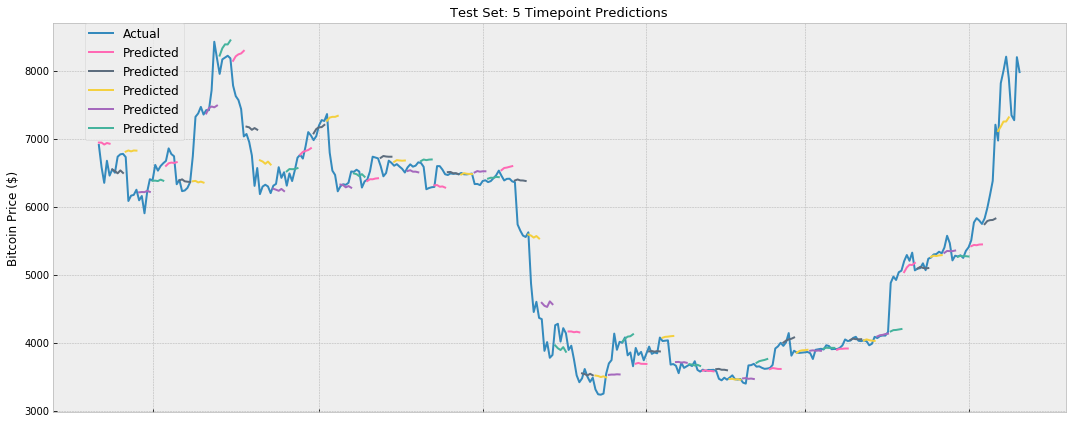

In [42]:
# little bit of reformatting the predictions to closing prices
bt_pred_prices = ((btc_model.predict(LSTM_test_inputs)[:-pred_range][::pred_range]+1)*\
                   test_set['Close'].values[:-(window_len + pred_range)][::5].reshape(int(np.ceil((len(LSTM_test_inputs)-pred_range)/float(pred_range))),1))

pred_colors = ["#FF69B4", "#5D6D7E", "#F4D03F","#A569BD","#45B39D"]
fig, ax1 = plt.subplots(1,1)
ax1.plot(test_set['Close'][window_len:], label='Actual')

for i, bt_pred in enumerate(bt_pred_prices):
    # Only adding lines to the legend once
    if i<5:
        ax1.plot(test_set.index[window_len:][i*pred_range:i*pred_range+pred_range],
                 bt_pred, color=pred_colors[i%5], label="Predicted")
    else: 
        ax1.plot(test_set.index[window_len:][i*pred_range:i*pred_range+pred_range],
                 bt_pred, color=pred_colors[i%5])
ax1.set_title('Test Set: 5 Timepoint Predictions',fontsize=13)
ax1.set_ylabel('Bitcoin Price ($)',fontsize=12)
ax1.set_xticklabels('')
ax1.legend(bbox_to_anchor=(0.13, 1), loc=1, borderaxespad=0., prop={'size': 12})
fig.tight_layout()

In [51]:
#load dataset

btc_bloackchain_dataset = pd.read_csv('bitcoin_blockchain_dataset.csv', parse_dates = ['Date'])


In [155]:
#set index

btc_bloackchain_dataset.set_index(btc_bloackchain_dataset['Date'], inplace=True)
btc_bloackchain_dataset.sort_index(inplace=True)
btc_bloackchain_dataset.drop('Date', axis = 1, inplace=True)
btc_bloackchain_dataset.drop(['btc_market_cap','btc_n_orphaned_blocks','btc_total_bitcoins', 'btc_blocks_size', 'btc_n_transactions_total'], axis = 1, inplace=True)

In [156]:
btc_bloackchain_dataset['btc_trade_volume'] = btc_bloackchain_dataset['btc_trade_volume'].fillna(method = 'ffill')
btc_bloackchain_dataset['btc_n_unique_addresses'] = btc_bloackchain_dataset['btc_n_unique_addresses'].fillna(method = 'ffill')
btc_bloackchain_dataset['btc_n_transactions_excluding_chains_longer_than_100'] = btc_bloackchain_dataset['btc_n_transactions_excluding_chains_longer_than_100'].fillna(method = 'ffill')

In [157]:
btc_bloackchain_dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2190 entries, 2013-05-22 to 2019-05-20
Data columns (total 18 columns):
btc_market_price                                       2190 non-null float64
btc_trade_volume                                       2190 non-null float64
btc_avg_block_size                                     2190 non-null float64
btc_n_transactions_per_block                           2190 non-null float64
btc_median_confirmation_time                           2190 non-null float64
btc_hash_rate                                          2190 non-null float64
btc_difficulty                                         2190 non-null float64
btc_miners_revenue                                     2190 non-null float64
btc_transaction_fees                                   2190 non-null float64
btc_cost_per_transaction_percent                       2190 non-null float64
btc_cost_per_transaction                               2190 non-null float64
btc_n_unique_addresses      

In [159]:
btc_bloackchain_dataset_mod = btc_bloackchain_dataset.copy()

In [160]:
btc_bloackchain_dataset_mod['Btc_market_price'] = btc_bloackchain_dataset.btc_market_price
btc_bloackchain_dataset_mod.drop("btc_market_price", axis=1, inplace=True)

In [161]:
btc_bloackchain_dataset_mod.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2190 entries, 2013-05-22 to 2019-05-20
Data columns (total 18 columns):
btc_trade_volume                                       2190 non-null float64
btc_avg_block_size                                     2190 non-null float64
btc_n_transactions_per_block                           2190 non-null float64
btc_median_confirmation_time                           2190 non-null float64
btc_hash_rate                                          2190 non-null float64
btc_difficulty                                         2190 non-null float64
btc_miners_revenue                                     2190 non-null float64
btc_transaction_fees                                   2190 non-null float64
btc_cost_per_transaction_percent                       2190 non-null float64
btc_cost_per_transaction                               2190 non-null float64
btc_n_unique_addresses                                 2190 non-null float64
btc_n_transactions          

In [11]:
# from practical time series analysis (univariate time series)

#shape of the datafarme

btc_bloackchain_dataset.shape

(2190, 18)

In [13]:
# rescaling
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
btc_bloackchain_dataset['btc_market_price'] = scaler.fit_transform(np.array(btc_bloackchain_dataset['btc_market_price']).reshape(-1, 1))

In [14]:
#train-test split
split_date = '2018-06-01'
df_train = btc_bloackchain_dataset.loc[btc_bloackchain_dataset.index < split_date]
df_val = btc_bloackchain_dataset.loc[btc_bloackchain_dataset.index >= split_date]
print('Shape of train:', df_train.shape)
print('Shape of test:', df_val.shape)

Shape of train: (1836, 18)
Shape of test: (354, 18)


In [15]:
df_train.reset_index(inplace=True)
df_val.reset_index(inplace=True)

D:\andrea\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)
D:\andrea\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


Text(0, 0.5, 'Scaled BTC market Price')

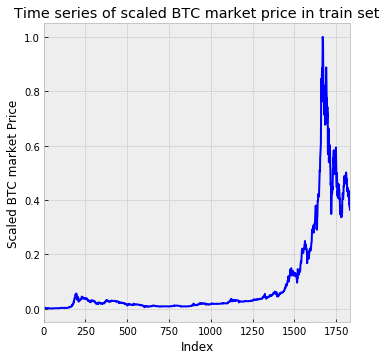

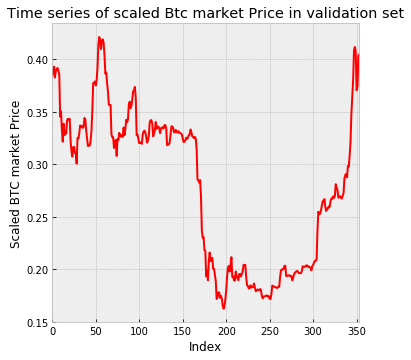

In [16]:
#plot train and validation

"""
The train and validation time series of standardized PRES is also plotted.
"""

plt.figure(figsize=(5.5, 5.5))
g = sns.tsplot(df_train['btc_market_price'], color='b')
g.set_title('Time series of scaled BTC market price in train set')
g.set_xlabel('Index')
g.set_ylabel('Scaled BTC market Price')

plt.figure(figsize=(5.5, 5.5))
g = sns.tsplot(df_val['btc_market_price'], color='r')
g.set_title('Time series of scaled Btc market Price in validation set')
g.set_xlabel('Index')
g.set_ylabel('Scaled BTC market Price')

In [17]:
btc_bloackchain_dataset.reset_index(inplace=True)

In [18]:
#consider nb_timesteps to forecast the next observation. One time forecast

def makeXy(ts, nb_timesteps):
    """
    Input: 
           ts: original time series
           nb_timesteps: number of time steps in the regressors
    Output: 
           X: 2-D array of regressors
           y: 1-D array of target 
    """
    X = []
    y = []
    for i in range(nb_timesteps, ts.shape[0]):
        X.append(list(ts.loc[i-nb_timesteps:i-1]))
        y.append(ts.loc[i])
    X, y = np.array(X), np.array(y)
    return X, y

In [19]:
X_train, y_train = makeXy(df_train['btc_market_price'], 15)
print('Shape of train arrays:', X_train.shape, y_train.shape)




Shape of train arrays: (1821, 15) (1821,)


In [20]:
X_val, y_val = makeXy(df_val['btc_market_price'], 15)
print('Shape of train arrays:', X_val.shape, y_val.shape)

Shape of train arrays: (339, 15) (339,)


In [52]:
btc_bloackchain_dataset['btc_market_price']

0        122.640000
1        125.670000
2        131.500000
3        132.690000
4        134.047010
5        132.609970
6        128.321000
7        129.979940
8        130.995890
9        127.340720
10       129.199450
11       120.602930
12       120.000020
13       120.566630
14       122.405100
15       120.689980
16       110.295010
17       107.800000
18        98.470450
19       104.968510
20       108.000000
21       108.162010
22       109.000000
23       100.000000
24       101.969980
25       100.000000
26       100.525210
27       107.389990
28       107.835000
29       111.970000
           ...     
2160    5274.145833
2161    5305.275000
2162    5527.801667
2163    5465.515000
2164    5421.526667
2165    5280.616667
2166    5281.809167
2167    5306.695000
2168    5277.883333
2169    5262.363333
2170    5310.173333
2171    5364.991667
2172    5633.747500
2173    5697.923333
2174    5718.229167
2175    5654.353333
2176    5863.523333
2177    5851.670769
2178    6056.417500


In [21]:
X_train, X_val = X_train.reshape((X_train.shape[0], X_train.shape[1], 1)) ,  X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
print('Shape of 3D arrays:', X_train.shape, X_val.shape)

Shape of 3D arrays: (1821, 15, 1) (339, 15, 1)


In [22]:
from keras.layers import Dense, Input, Dropout
from keras.layers.recurrent import LSTM
from keras.optimizers import SGD
from keras.models import Model
from keras.models import load_model
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [23]:
#Define input layer which has shape (None, 14) and of type float32. None indicates the number of instances
input_layer = Input(shape=(15,1), dtype='float32')

In [24]:
#LSTM layer is defined for seven timesteps
lstm_layer = LSTM(64, input_shape=(15,1), return_sequences=False)(input_layer)

Instructions for updating:
Colocations handled automatically by placer.


In [25]:
dropout_layer = Dropout(0.2)(lstm_layer)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [26]:
#Finally the output layer gives prediction for the next day's air pressure.
output_layer = Dense(1, activation='linear')(dropout_layer)

In [27]:
ts_model = Model(inputs=input_layer, outputs=output_layer)
ts_model.compile(loss='mae', optimizer='adam')
ts_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 15, 1)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                16896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________


In [35]:
"""
The model is trained by calling the fit function on the model object and passing the X_train and y_train. The training 
is done for a predefined number of epochs. Additionally, batch_size defines the number of samples of train set to be
used for a instance of back propagation.The validation dataset is also passed to evaluate the model after every epoch
completes. A ModelCheckpoint object tracks the loss function on the validation set and saves the model for the epoch,
at which the loss function has been minimum.
"""
save_weights_at = 'BTC_LSTM_weights.{epoch:02d}-{val_loss:.4f}.hdf5'
save_best = ModelCheckpoint(save_weights_at, monitor='val_loss', verbose=0,
                            save_best_only=True, save_weights_only=False, mode='min',
                            period=1)
ts_model.fit(x=X_train, y=y_train, batch_size=16, epochs=20,
             verbose=1, callbacks=[save_best], validation_data=(X_val, y_val))

Train on 1821 samples, validate on 339 samples
Epoch 1/20
1821/1821 [==============================] - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.007 - ETA: 0s - loss: 0.007 - ETA: 0s - loss: 0.007 - ETA: 0s - loss: 0.007 - ETA: 0s - loss: 0.008 - ETA: 0s - loss: 0.007 - ETA: 0s - loss: 0.007 - ETA: 0s - loss: 0.007 - ETA: 0s - loss: 0.007 - ETA: 0s - loss: 0.007 - ETA: 0s - loss: 0.007 - ETA: 0s - loss: 0.007 - 1s 393us/step - loss: 0.0078 - val_loss: 0.0088
Epoch 2/20
1821/1821 [==============================] - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.007 - ETA: 0s - loss: 0.007 - ETA: 0s - loss: 0.007 - ETA: 0s - loss: 0.008 - ETA: 0s - loss: 0.008 - ETA: 0s - loss: 0.008 - ETA: 0s - loss: 0.008 - 1s 394us/step - loss: 0.0084 - val_loss: 0.0086
Epoch 3/20
1821/1821 [==============================] - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0

In [37]:

best_model = load_model("BTC_LSTM_weights.18-0.0067.hdf5") #make it work
preds = best_model.predict(X_val)
pred_BTC = scaler.inverse_transform(preds)
pred_BTC = np.squeeze(pred_BTC)

In [54]:
len(pred_BTC)

339

Text(0.5, 0, 'Index')

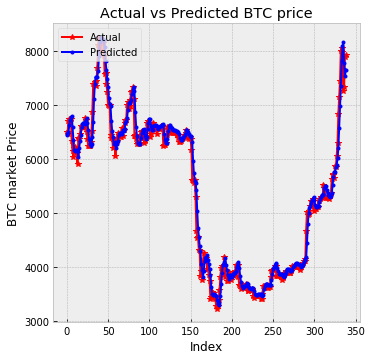

In [56]:
#Let's plot the first 50 actual and predicted values of air pressure.
plt.figure(figsize=(5.5, 5.5))
plt.plot(btc_bloackchain_dataset['btc_market_price'][-339:].values, linestyle='-', marker='*', color='r')
plt.plot(pred_BTC, linestyle='-', marker='.', color='b')
plt.legend(['Actual','Predicted'], loc=2)
plt.title('Actual vs Predicted BTC price')
plt.ylabel('BTC market Price')
plt.xlabel('Index')


In [ ]:
# https://github.com/dashee87/blogScripts/blob/master/Jupyter/2017-09-06-another-keras-tutorial-for-neural-network-beginners.ipynb

#define the final model network function and display the loss and accuracy 

In [6]:
#working with os.path
os.path.abspath(os.path.curdir)

'C:\\Users\\Andrea\\Jupyter Notebooks\\Master Thesis'

In [11]:
save_weights_at = os.path.join('C:\\Users\\Andrea\\Jupyter Notebooks\\Master Thesis', 'PRSA_data_Air_Pressure_LSTM_weights.{epoch:02d}-{val_loss:.4f}.hdf5')

In [12]:
save_weights_at

'C:\\Users\\Andrea\\Jupyter Notebooks\\Master Thesis\\PRSA_data_Air_Pressure_LSTM_weights.{epoch:02d}-{val_loss:.4f}.hdf5'

In [ ]:
#https://www.altumintelligence.com/articles/a/Time-Series-Prediction-Using-LSTM-Deep-Neural-Networks

In [133]:
config = dict(["data" : {
    "columns": [
        "btc_market_price",                                       
        "btc_trade_volume",                                       
        "btc_avg_block_size",                                     
        "btc_n_transactions_per_block",                           
        "btc_median_confirmation_time",                           
        "btc_hash_rate",                                         
        "btc_difficulty",                                         
        "btc_miners_revenue",                                     
        "btc_transaction_fees",                                   
        "btc_cost_per_transaction_percent",                       
        "btc_cost_per_transaction",                               
        "btc_n_unique_addresses",                                 
        "btc_n_transactions",                                    
        "btc_n_transactions_excluding_popular",                   
        "btc_n_transactions_excluding_chains_longer_than_100",    
        "btc_output_volume",                                     
        "btc_estimated_transaction_volume",                       
        "btc_estimated_transaction_volume_usd"                   
    ],
    "sequence_length": 15,
    "train_test_split": 0.90,
    "normalise": True
},
              "training": {
                  "epochs": 20,
                  "batch_size": 30
              },
              "model":{
                  "loss": "mse",
                  "optimizer": "adam",
                  "save_dir": "saved_models",
                  "layers": [
                      {
                          "type":"lstm",
                          "neurons": 32,
                          "input_timesteps": 14,
                          "input_dim" : 18,
                          "return_seq": true
                      },
                      {
                          "type": "dropout",
                          "rate": 0.2
                      },
                      {
                          "type": "lstm",
                          "neurons": 32,
                          "return_seq": true
                      },
                      {
                          "type":"lstm",
                          "neurons":32,
                          "return_seq": false
                      },
                      {
                          "type": "dropout",
                          "rate": 0.2
                      },
                      {
                          "type": "dense",
                          "neurons": 1,
                          "activation": "linear"
                      }
                  ]
              }
             )

SyntaxError: invalid syntax (<ipython-input-133-0a32943844fd>, line 1)

In [209]:
config = {}
config["data"] =  {
    "columns": [
        "Btc_market_price",                                       
        "btc_trade_volume",                                       
        #"btc_avg_block_size",                                     
        #"btc_n_transactions_per_block",                           
        #"btc_median_confirmation_time",                           
        "btc_hash_rate",                                         
        #"btc_difficulty",                                         
        "btc_miners_revenue",                                     
        #"btc_transaction_fees",                                   
        "btc_cost_per_transaction_percent",                       
        #"btc_cost_per_transaction",                               
        "btc_n_unique_addresses"                                 
        #"btc_n_transactions",                                    
        #btc_n_transactions_excluding_popular",                   
        #"btc_n_transactions_excluding_chains_longer_than_100",    
        #"btc_output_volume",                                     
        #"btc_estimated_transaction_volume",                       
        #"btc_estimated_transaction_volume_usd"                   
    ],
    "sequence_length": 15,
    "train_test_split": 0.85,
    "normalise": True
}

config["training"] = {
    "epochs": 10,
    "batch_size": 100
}

config["model"] = {
    "loss": "mse",
    "optimizer": "adam",
    "save_dir": "saved_models",
    "layers": [
        {
            "type":"lstm",
            "neurons": 32,
            "input_timesteps": 14,
            "input_dim" : 6,
            "return_seq": True
        },
        {
            "type": "dropout",
            "rate": 0.2
        },
        {
            "type": "lstm",
            "neurons": 32,
            "return_seq": True
        },
        {
            "type":"lstm",
            "neurons":32,
            "return_seq": False
        },
        {
            "type": "dropout",
            "rate": 0.2
        },
        {
            "type": "dense",
            "neurons": 1,
            "activation": "linear"
        }
    ]
}
              

In [ ]:
config = {}
config["data"] =  {"columns": ["Btc_market_price", "btc_trade_volume", "btc_hash_rate","btc_miners_revenue",
                               "btc_cost_per_transaction_percent", "btc_n_unique_addresses"], "sequence_length": 15,
                   "train_test_split": 0.85, "normalise": True}

config["training"] = {"epochs": 10, "batch_size": 100}

config["model"] = {"loss": "mse",
                   "optimizer": "adam",
                   "save_dir": "saved_models",
                   "layers": [{"type":"lstm","neurons": 32,
                               "input_timesteps": 14,
                               "input_dim" : 6,"return_seq": True},
                              {"type": "dropout","rate": 0.2},
                              {"type": "lstm","neurons": 32,"return_seq": True}, 
                              {"type":"lstm","neurons":32,"return_seq": False},
                              {"type": "dropout","rate": 0.2},
                              {"type": "dense","neurons": 1,"activation": "linear"}]}
              

In [200]:

class Timer():

    def __init__(self):
        self.start_dt = None

    def start(self):
        self.start_dt = dt.datetime.now()

    def stop(self):
        end_dt = dt.datetime.now()
        print('Time taken: %s' % (end_dt - self.start_dt))

In [201]:
#data_preprocessor

class DataLoader():
    """A class for loading and transforming data for the lstm model"""

    def __init__(self, filename, split, cols):
        dataframe = filename
        i_split = int(len(dataframe) * split)
        self.data_train = dataframe.get(cols).values[:i_split]
        self.data_test  = dataframe.get(cols).values[i_split:]
        self.len_train  = len(self.data_train)
        self.len_test   = len(self.data_test)
        self.len_train_windows = None

    def get_test_data(self, seq_len, normalise):
        '''
        Create x, y test data windows
        Warning: batch method, not generative, make sure you have enough memory to
        load data, otherwise reduce size of the training split.
        '''
        data_windows = []
        for i in range(self.len_test - seq_len):
            data_windows.append(self.data_test[i:i+seq_len])

        data_windows = np.array(data_windows).astype(float)
        data_windows = self.normalise_windows(data_windows, single_window=False) if normalise else data_windows

        x = data_windows[:, :-1]
        y = data_windows[:, -1, [0]]
        return x,y

    def get_train_data(self, seq_len, normalise):
        '''
        Create x, y train data windows
        Warning: batch method, not generative, make sure you have enough memory to
        load data, otherwise use generate_training_window() method.
        '''
        data_x = []
        data_y = []
        for i in range(self.len_train - seq_len):
            x, y = self._next_window(i, seq_len, normalise)
            data_x.append(x)
            data_y.append(y)
        return np.array(data_x), np.array(data_y)

    def generate_train_batch(self, seq_len, batch_size, normalise):
        '''Yield a generator of training data from filename on given list of cols split for train/test'''
        i = 0
        while i < (self.len_train - seq_len):
            x_batch = []
            y_batch = []
            for b in range(batch_size):
                if i >= (self.len_train - seq_len):
                    # stop-condition for a smaller final batch if data doesn't divide evenly
                    yield np.array(x_batch), np.array(y_batch)
                    i = 0
                x, y = self._next_window(i, seq_len, normalise)
                x_batch.append(x)
                y_batch.append(y)
                i += 1
            yield np.array(x_batch), np.array(y_batch)

    def _next_window(self, i, seq_len, normalise):
        '''Generates the next data window from the given index location i'''
        window = self.data_train[i:i+seq_len]
        window = self.normalise_windows(window, single_window=True)[0] if normalise else window
        x = window[:-1]
        y = window[-1, [0]]
        return x, y

    def normalise_windows(self, window_data, single_window=False):
        '''Normalise window with a base value of zero'''
        normalised_data = []
        window_data = [window_data] if single_window else window_data
        for window in window_data:
            normalised_window = []
            for col_i in range(window.shape[1]):
                normalised_col = [((float(p) / float(window[0, col_i])) - 1) for p in window[:, col_i]]
                normalised_window.append(normalised_col)
            normalised_window = np.array(normalised_window).T # reshape and transpose array back into original multidimensional format
            normalised_data.append(normalised_window)
        return np.array(normalised_data)

In [202]:
import os
import math
import numpy as np
import datetime as dt
from numpy import newaxis
from keras.layers import Dense, Activation, Dropout, LSTM
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [203]:
class Model():
    """A class for an building and inferencing an lstm model"""

    def __init__(self):
        self.model = Sequential()

    def load_model(self, filepath):
        print('[Model] Loading model from file %s' % filepath)
        self.model = load_model(filepath)

    def build_model(self, configs):
        timer = Timer()
        timer.start()

        for layer in configs['model']['layers']:
            neurons = layer['neurons'] if 'neurons' in layer else None
            dropout_rate = layer['rate'] if 'rate' in layer else None
            activation = layer['activation'] if 'activation' in layer else None
            return_seq = layer['return_seq'] if 'return_seq' in layer else None
            input_timesteps = layer['input_timesteps'] if 'input_timesteps' in layer else None
            input_dim = layer['input_dim'] if 'input_dim' in layer else None

            if layer['type'] == 'dense':
                self.model.add(Dense(neurons, activation=activation))
            if layer['type'] == 'lstm':
                self.model.add(LSTM(neurons, input_shape=(input_timesteps, input_dim), return_sequences=return_seq))
            if layer['type'] == 'dropout':
                self.model.add(Dropout(dropout_rate))

        self.model.compile(loss=configs['model']['loss'], optimizer=configs['model']['optimizer'])

        print('[Model] Model Compiled')
        timer.stop()

    def train(self, x, y, epochs, batch_size, save_dir):
        timer = Timer()
        timer.start()
        print('[Model] Training Started')
        print('[Model] %s epochs, %s batch size' % (epochs, batch_size))

        save_fname = save_dir + '_%s-e%s.h5' % (dt.datetime.now().strftime('%d%m%Y-%H%M%S'), str(epochs))
        callbacks = [
            EarlyStopping(monitor='val_loss', patience=2),
            ModelCheckpoint(filepath=save_fname, monitor='val_loss', save_best_only=True)
        ]
        self.model.fit(
            x,
            y,
            epochs=epochs,
            batch_size=batch_size,
            callbacks=callbacks
        )
        self.model.save(save_fname)

        print('[Model] Training Completed. Model saved as %s' % save_fname)
        timer.stop()

    def train_generator(self, data_gen, epochs, batch_size, steps_per_epoch, save_dir):
        timer = Timer()
        timer.start()
        print('[Model] Training Started')
        print('[Model] %s epochs, %s batch size, %s batches per epoch' % (epochs, batch_size, steps_per_epoch))
        
        save_fname = save_dir + '_%s-e%s.h5' % (dt.datetime.now().strftime('%d%m%Y-%H%M%S'), str(epochs))
        callbacks = [
            ModelCheckpoint(filepath=save_fname, monitor='loss', save_best_only=True)
        ]
        self.model.fit_generator(
            data_gen,
            steps_per_epoch=steps_per_epoch,
            epochs=epochs,
            callbacks=callbacks,
            workers=1
        )
        
        print('[Model] Training Completed. Model saved as %s' % save_fname)
        timer.stop()

    def predict_point_by_point(self, data):
        #Predict each timestep given the last sequence of true data, in effect only predicting 1 step ahead each time
        print('[Model] Predicting Point-by-Point...')
        predicted = self.model.predict(data)
        predicted = np.reshape(predicted, (predicted.size,))
        return predicted

    def predict_sequences_multiple(self, data, window_size, prediction_len):
        print('[Model] Predicting Sequences Multiple...')
        prediction_seqs = []
        for i in range(int(len(data)/prediction_len)):
            curr_frame = data[i*prediction_len]
            predicted = []
            for j in range(prediction_len):
                predicted.append(self.model.predict(curr_frame[newaxis,:,:])[0,0])
                curr_frame = curr_frame[1:]
                curr_frame = np.insert(curr_frame, [window_size-2], predicted[-1], axis=0)
            prediction_seqs.append(predicted)
        return prediction_seqs

    def predict_sequence_full(self, data, window_size):
        #Shift the window by 1 new prediction each time, re-run predictions on new window
        print('[Model] Predicting Sequences Full...')
        curr_frame = data[0]
        predicted = []
        for i in range(len(data)):
            predicted.append(self.model.predict(curr_frame[newaxis,:,:])[0,0])
            curr_frame = curr_frame[1:]
            curr_frame = np.insert(curr_frame, [window_size-2], predicted[-1], axis=0)
        return predicted

In [204]:
def plot_results(predicted_data, true_data):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    plt.plot(predicted_data, label='Prediction')
    plt.legend()


def plot_results_multiple(predicted_data, true_data, prediction_len):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    # Pad the list of predictions to shift it in the graph to it's correct start
    for i, data in enumerate(predicted_data):
        padding = [None for p in range(i * prediction_len)]
        plt.plot(padding + data, label='Prediction')
        plt.legend()


In [88]:
#run the model

In [205]:
btc_bloackchain_dataset_mod.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2190 entries, 2013-05-22 to 2019-05-20
Data columns (total 18 columns):
btc_trade_volume                                       2190 non-null float64
btc_avg_block_size                                     2190 non-null float64
btc_n_transactions_per_block                           2190 non-null float64
btc_median_confirmation_time                           2190 non-null float64
btc_hash_rate                                          2190 non-null float64
btc_difficulty                                         2190 non-null float64
btc_miners_revenue                                     2190 non-null float64
btc_transaction_fees                                   2190 non-null float64
btc_cost_per_transaction_percent                       2190 non-null float64
btc_cost_per_transaction                               2190 non-null float64
btc_n_unique_addresses                                 2190 non-null float64
btc_n_transactions          

In [210]:
data = DataLoader(btc_bloackchain_dataset_mod, config['data']['train_test_split'], config['data']['columns'])

In [211]:
model = Model()
model.build_model(config)
x, y = data.get_train_data(seq_len=config['data']['sequence_length'], normalise=config['data']['normalise'])

[Model] Model Compiled
Time taken: 0:00:00.789888


In [212]:
steps_per_epoch = math.ceil((data.len_train - config['data']['sequence_length']) / config['training']['batch_size'])
model.train_generator(data_gen=data.generate_train_batch(seq_len=config['data']['sequence_length'],
                                                         batch_size=config['training']['batch_size'],
                                                         normalise=config['data']['normalise']),
                      epochs=config['training']['epochs'],
                      batch_size=config['training']['batch_size'],
                      steps_per_epoch=steps_per_epoch,
                      save_dir=config['model']['save_dir'])

[Model] Training Started
[Model] 10 epochs, 100 batch size, 19 batches per epoch
Epoch 1/10
19/19 [==============================] - ETA: 1:55 - loss: 0.031 - ETA: 34s - loss: 0.186 - ETA: 18s - loss: 0.12 - ETA: 14s - loss: 0.10 - ETA: 11s - loss: 0.09 - ETA: 7s - loss: 0.0750 - ETA: 4s - loss: 0.062 - ETA: 3s - loss: 0.054 - ETA: 1s - loss: 0.050 - ETA: 0s - loss: 0.052 - ETA: 0s - loss: 0.051 - 7s 377ms/step - loss: 0.0502
Epoch 2/10
19/19 [==============================] - ETA: 0s - loss: 0.034 - ETA: 0s - loss: 0.132 - ETA: 0s - loss: 0.089 - ETA: 0s - loss: 0.071 - ETA: 0s - loss: 0.056 - ETA: 0s - loss: 0.048 - ETA: 0s - loss: 0.042 - ETA: 0s - loss: 0.038 - ETA: 0s - loss: 0.039 - ETA: 0s - loss: 0.039 - 1s 36ms/step - loss: 0.0381
Epoch 3/10
19/19 [==============================] - ETA: 0s - loss: 0.018 - ETA: 0s - loss: 0.097 - ETA: 0s - loss: 0.065 - ETA: 0s - loss: 0.052 - ETA: 0s - loss: 0.042 - ETA: 0s - loss: 0.036 - ETA: 0s - loss: 0.031 - ETA: 0s - loss: 0.028 - ETA: 0

In [213]:
x_test, y_test = data.get_test_data(seq_len=config['data']['sequence_length'], normalise=config['data']['normalise'])

In [214]:
predictions_Mult_seq = model.predict_sequences_multiple(x_test, config['data']['sequence_length'], config['data']['sequence_length'])
predictions_full = model.predict_sequence_full(x_test, config['data']['sequence_length'])
predictions_one = model.predict_point_by_point(x_test)

[Model] Predicting Sequences Multiple...
[Model] Predicting Sequences Full...
[Model] Predicting Point-by-Point...


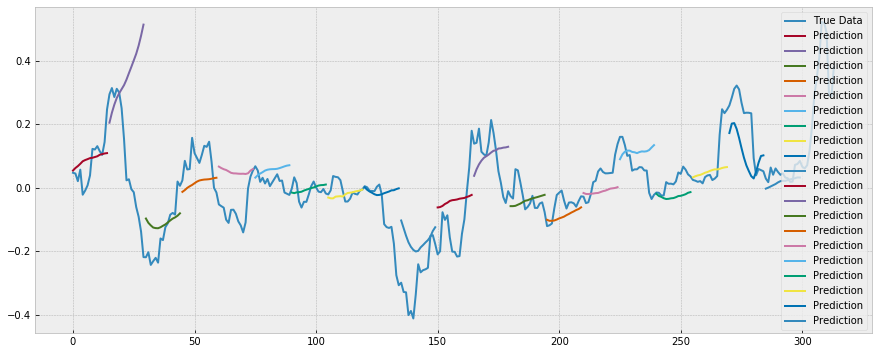

In [219]:
plot_results_multiple(predictions_Mult_seq, y_test, config['data']['sequence_length'])
plt.savefig('LSTM_multi_step_prediction_15_days.png', format='png', dpi=300)

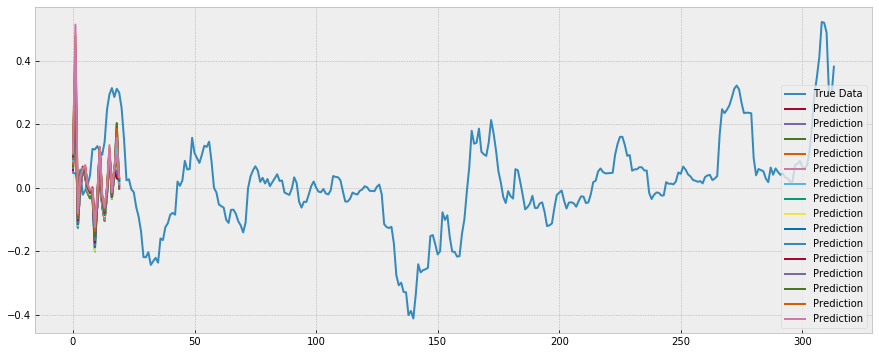

In [218]:
plot_results(predictions_Mult_seq, y_test)

In [216]:
#configuration neural network

config["model"]

{'loss': 'mse',
 'optimizer': 'adam',
 'save_dir': 'saved_models',
 'layers': [{'type': 'lstm',
   'neurons': 32,
   'input_timesteps': 14,
   'input_dim': 6,
   'return_seq': True},
  {'type': 'dropout', 'rate': 0.2},
  {'type': 'lstm', 'neurons': 32, 'return_seq': True},
  {'type': 'lstm', 'neurons': 32, 'return_seq': False},
  {'type': 'dropout', 'rate': 0.2},
  {'type': 'dense', 'neurons': 1, 'activation': 'linear'}]}

In [110]:
x_test

array([[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [-1.82195496e-02, -4.73981357e-02,  1.91565976e-02, ...,
          1.27804232e-01,  3.27389554e-01,  3.04716995e-01],
        [-1.78012632e-02, -2.76142830e-01, -3.54219784e-01, ...,
          3.80296509e-02,  1.73643520e-01,  1.54388363e-01],
        ...,
        [-3.68920418e-03,  6.52805896e-01, -4.27205227e-01, ...,
         -8.95613892e-02, -1.61470189e-01, -1.67954846e-01],
        [ 1.48806389e-02,  2.16470636e-01, -4.52462239e-01, ...,
         -3.10599956e-01, -4.58216727e-01, -4.52386543e-01],
        [ 2.06598114e-02,  1.06627433e-01, -1.50895501e-01, ...,
          4.70592744e-02,  3.48984679e-01,  3.71265609e-01]],

       [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 4.26048839e-04, -2.40126230e-01, -3.66358205e-01, ...,
         -7.96012097e-02, -1.15825858e